In [56]:
import numpy as np
import matplotlib.pyplot as plt

In [57]:
data_orig = np.genfromtxt('data/housepricedata.csv',delimiter=',',skip_header=1)
print("Dataset : \n\n"+ str(data_orig))
print("\nDimensions of dataset : "+str(data_orig.shape))

Dataset : 

[[8.450e+03 7.000e+00 5.000e+00 ... 0.000e+00 5.480e+02 1.000e+00]
 [9.600e+03 6.000e+00 8.000e+00 ... 1.000e+00 4.600e+02 1.000e+00]
 [1.125e+04 7.000e+00 5.000e+00 ... 1.000e+00 6.080e+02 1.000e+00]
 ...
 [9.042e+03 7.000e+00 9.000e+00 ... 2.000e+00 2.520e+02 1.000e+00]
 [9.717e+03 5.000e+00 6.000e+00 ... 0.000e+00 2.400e+02 0.000e+00]
 [9.937e+03 5.000e+00 6.000e+00 ... 0.000e+00 2.760e+02 0.000e+00]]

Dimensions of dataset : (1460, 11)


In [59]:
#Seed for np.random
seed=16
np.random.seed(seed)

In [4]:
#Shuffling imported original dataset
np.random.shuffle(data_orig)

In [5]:
#Shuffled dataset
print("Shuffled dataset with (Seed "+str(seed) +") :\n\n"+str(data_orig))
print("\n"+str(data_orig.shape))

Shuffled dataset with (Seed 0) :

[[3.2668e+04 6.0000e+00 3.0000e+00 ... 2.0000e+00 4.8400e+02 1.0000e+00]
 [9.4900e+03 6.0000e+00 7.0000e+00 ... 2.0000e+00 2.4000e+02 0.0000e+00]
 [7.0150e+03 5.0000e+00 4.0000e+00 ... 1.0000e+00 3.5200e+02 0.0000e+00]
 ...
 [8.9300e+03 6.0000e+00 5.0000e+00 ... 0.0000e+00 5.3900e+02 0.0000e+00]
 [3.1960e+03 7.0000e+00 5.0000e+00 ... 1.0000e+00 4.2000e+02 1.0000e+00]
 [1.6770e+04 7.0000e+00 5.0000e+00 ... 0.0000e+00 4.8600e+02 1.0000e+00]]

(1460, 11)


In [6]:
#Extacting Y
y_orig = data_orig[:,-1]
print("Output Y   :"+str(y_orig))
print("Shape of Y : "+str(y_orig.shape))

Output Y   :[1. 0. 0. ... 0. 1. 1.]
Shape of Y : (1460,)


In [7]:
Y = np.reshape(y_orig,(y_orig.shape[0],1)).T    
print("Shape of Y: "+ str(Y.shape))

Shape of Y: (1, 1460)


In [8]:
#Extracting vectorized input feature X (transposed)
x_shuffled = data_orig[:,0:-1].T
print("Input set : \n\n" +str(x_shuffled))

Input set : 

[[3.2668e+04 9.4900e+03 7.0150e+03 ... 8.9300e+03 3.1960e+03 1.6770e+04]
 [6.0000e+00 6.0000e+00 5.0000e+00 ... 6.0000e+00 7.0000e+00 7.0000e+00]
 [3.0000e+00 7.0000e+00 4.0000e+00 ... 5.0000e+00 5.0000e+00 5.0000e+00]
 ...
 [9.0000e+00 5.0000e+00 5.0000e+00 ... 8.0000e+00 7.0000e+00 7.0000e+00]
 [2.0000e+00 2.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [4.8400e+02 2.4000e+02 3.5200e+02 ... 5.3900e+02 4.2000e+02 4.8600e+02]]


In [9]:
print(x_shuffled.shape)
X=x_shuffled

(10, 1460)


In [10]:
#Splitting into Train, Test sets ( with a fixed seed )
train_split_percent = 80
test_split_percent = 20

train_X , test_X = X[:, : int( (train_split_percent/100)*X.shape[1])] , X[:,int( (train_split_percent/100)*X.shape[1]) : ]
train_Y , test_Y = Y[:, : int( (train_split_percent/100)*X.shape[1])] , Y[:,int( (train_split_percent/100)*X.shape[1]) : ]
print("Seed of Randomization   : "+str(seed))
print("\nShape of Training set X : "+str(train_X.shape))
print("Shape of Training set Y : "+str(train_Y.shape))
print("\nShape of Test set   X   : "+str(test_X.shape))
print("Shape of Test set Y     : "+str(test_Y.shape))

Seed of Randomization   : 0

Shape of Training set X : (10, 1168)
Shape of Training set Y : (1, 1168)

Shape of Test set   X   : (10, 292)
Shape of Test set Y     : (1, 292)


In [11]:
m_train = train_X.shape[1]
m_test  = test_X.shape[1]
print("No of training examples : "+str(m_train))
print("No of test example      : "+str(m_test))

No of training examples : 1168
No of test example      : 292


In [12]:
def standardize(x):
    """
    Input  :  Numpy array x 
    Output :  Numpy array of same shape as X but standardized along each rows
    
    """
    x_mean = np.mean(x,axis=1, keepdims=True)
    x_std = np.std(x, axis=1, keepdims=True)

    #print("Mean of each row : \n\n"+str(x_mean))
    #print("\nStandard deviation of each row : \n\n"+str(x_std))

    X = (x - x_mean)/x_std   #Python Broadcasting

    return X

In [13]:
train_X = standardize(train_X)
print("Standardize train_X : "+str(train_X.shape)+"\n\n"+str(train_X))
test_X  = standardize(test_X)
print("\n\nStandardize test_X : "+str(test_X.shape)+"\n\n"+str(test_X))

Standardize train_X : (10, 1168)

[[ 2.23367899 -0.10698965 -0.35693162 ... -0.44731467 -0.10547485
   0.05761859]
 [-0.1092216  -0.1092216  -0.82190776 ... -1.53459392  0.60346457
  -0.1092216 ]
 [-2.30141054  1.25773876 -1.41162321 ...  1.25773876 -0.52183589
   0.36795144]
 ...
 [ 1.49172485 -0.94681206 -0.94681206 ... -0.33717784  0.88209062
  -0.33717784]
 [ 2.13529354  2.13529354  0.58621102 ... -0.9628715   0.58621102
  -0.9628715 ]
 [ 0.0308818  -1.08416503 -0.57234026 ... -1.08416503 -0.19761141
   0.17711745]]


Standardize test_X : (10, 292)

[[ 0.00911413 -0.15441423 -0.0605801  ... -0.14176025 -0.69989814
   0.62137212]
 [ 0.87623012 -1.47830235 -0.69345819 ...  0.09138596  0.87623012
   0.87623012]
 [ 0.44085645  1.38049211  1.38049211 ... -0.4987792  -0.4987792
  -0.4987792 ]
 ...
 [ 1.04502677  0.40125501 -0.88628853 ...  1.04502677  0.40125501
   0.40125501]
 [ 0.65932079 -0.90589605 -0.90589605 ... -0.90589605  0.65932079
  -0.90589605]
 [ 0.14167258 -2.38627965 -0.03

In [14]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [15]:
def initialize_parameters(n_x, n_h, n_y):
    
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters 

In [16]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
    return parameters

In [17]:
def linear_forward(A, W, b):
   
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    
    return Z, cache

In [18]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z), sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z), relu(Z)
    
    cache = (linear_cache, activation_cache)

    return A, cache

In [19]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], "relu")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)],activation = "sigmoid")
    caches.append(cache)
            
    return AL, caches

In [20]:
def compute_cost(AL, Y):
    
    m = Y.shape[1]
    cost = (-1/m)*(np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL)))
    cost = np.squeeze(cost)     
   
    return cost

In [21]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)

    return dA_prev, dW, db

In [22]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [23]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")

    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [24]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters

In [25]:
layers_dims = [10,5, 1]

In [26]:

def L_layer_model(X, Y, layers_dims, learning_rate = 0.003, num_iterations = 3000, print_cost=False):#lr was 0.009

    costs = []                      
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
    
        grads = L_model_backward(AL, Y, caches)
 
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693254
Cost after iteration 100: 0.693117
Cost after iteration 200: 0.692996
Cost after iteration 300: 0.692868
Cost after iteration 400: 0.692704
Cost after iteration 500: 0.692464
Cost after iteration 600: 0.692089
Cost after iteration 700: 0.691476
Cost after iteration 800: 0.690465
Cost after iteration 900: 0.688796
Cost after iteration 1000: 0.686052
Cost after iteration 1100: 0.681568
Cost after iteration 1200: 0.674334
Cost after iteration 1300: 0.662878
Cost after iteration 1400: 0.645238
Cost after iteration 1500: 0.619245
Cost after iteration 1600: 0.583206
Cost after iteration 1700: 0.537201
Cost after iteration 1800: 0.484246
Cost after iteration 1900: 0.430496
Cost after iteration 2000: 0.383436
Cost after iteration 2100: 0.347534
Cost after iteration 2200: 0.321766
Cost after iteration 2300: 0.303092
Cost after iteration 2400: 0.288442
Cost after iteration 2500: 0.275520
Cost after iteration 2600: 0.264190
Cost after iteration 2700: 0.255202
Cost

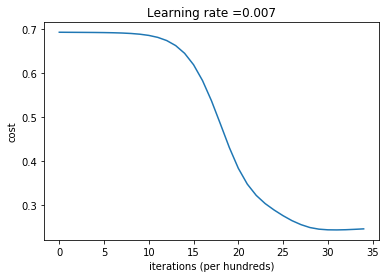

Train Accuracy = 89.72602739726028 %
Test Accuracy = 88.35616438356165 %


In [54]:
parameters = L_layer_model(train_X, train_Y, layers_dims = [10,8,1], num_iterations = 3500, learning_rate = 0.007, print_cost = True)

def predict(X,parameters):
    
    AL = L_model_forward(X, parameters)[0]
    Y_prediction = AL
    for i in range(AL.shape[1]):
          Y_prediction[0, i] = 1 if AL[0, i] > 0.5 else 0
   
    return Y_prediction 

test_Yhat = predict(test_X,parameters)
train_Yhat = predict(train_X,parameters)

test_accuracy =  np.mean(test_Yhat == test_Y)
train_accuracy = np.mean(train_Yhat == train_Y)

print("Train Accuracy = "+str(train_accuracy*100)+" %")
print("Test Accuracy = "+str(test_accuracy*100)+" %")